## Import libraries

In [147]:
# basic libs
import os
import numpy as np
import pandas as pd
import datetime

# data processing libs
import rasterio as rio
import xarray as xr
import rioxarray
import json
import requests
from pyproj import CRS
from osgeo import gdal
from math import ceil, floor

# plotting libs
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from odc.stac import stac_load
import planetary_computer
import pystac_client
import rich.table


## Some parameters

In [148]:

input_path = r"G:\Shared drives\Ryoko and Hilary\SMSigxSMAP\analysis\1_data"
appears_path = r".\APPEEARS_subsetting"
SMAPL3_path = r".\SPL3SMP_E"
SMAPL4_path = r".\SPL4SMGP"
SMAPL4_grid_path = r".\SMAPL4SMGP_EASEreference"
MODIS_path = r".\MOD15A2H"

network_name = "OZNET"

## 1. Load EASE grid

In [149]:
fn = "SMAP_L4_SM_lmc_00000000T000000_Vv7032_001.h5"
file_path = os.path.join(input_path, SMAPL4_grid_path, fn)
if os.path.exists(file_path):
    print('The file exists')
else:
    print('The file does NOT exist')

g = gdal.Open(file_path)
subdatasets = g.GetSubDatasets()

varname_lat = "cell_lat"
full_varname_lat = f'HDF5:"{file_path}"://{varname_lat}'

varname_lon = "cell_lon"
full_varname_lon = f'HDF5:"{file_path}"://{varname_lon}'

varname_ease_column = "cell_column"
full_varname_ease_column = f'HDF5:"{file_path}"://{varname_ease_column}'

varname_ease_row = "cell_row"
full_varname_ease_row = f'HDF5:"{file_path}"://{varname_ease_row}'

lat = rioxarray.open_rasterio(full_varname_lat)
lon = rioxarray.open_rasterio(full_varname_lon)
ease_column = rioxarray.open_rasterio(full_varname_ease_column)
ease_row = rioxarray.open_rasterio(full_varname_ease_row)


The file exists


c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

## Load Appears sample request

In [150]:
file_path = os.path.join(input_path, appears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)
coordinates = request_content['params']['coordinates']
dates = request_content['params']['dates']
coordinates
# dates

[{'id': '0',
  'category': 'Alabama',
  'latitude': -35.32395,
  'longitude': 147.5348}]

## Loop for the target coordinates (currently set i=0)

In [151]:
i=0
target_lat = coordinates[i]['latitude']
target_lon = coordinates[i]['longitude']
target_station = coordinates[i]['category']

## Load APPEEARS output (SMAPL3)

In [152]:
file_path = os.path.join(input_path, appears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

In [153]:
df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

## Load APPEEARS output (SMAPL4)

Index(['Category', 'ID', 'Latitude', 'Longitude', 'Date', 'SMAP_Tile',
       'SPL4SMGP_006_Line_Y_9km', 'SPL4SMGP_006_Sample_X_9km',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
       'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7'],
      dtype='object')


<AxesSubplot: >

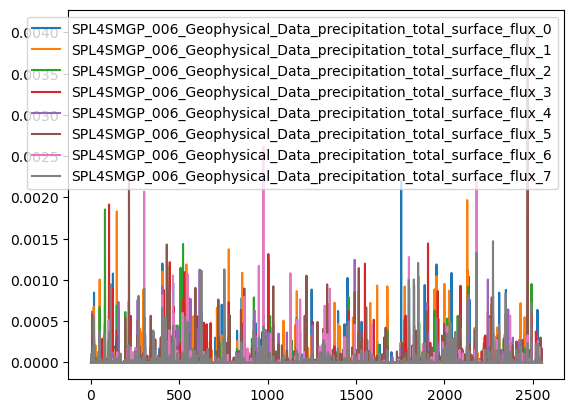

In [154]:
file_path = os.path.join(input_path, appears_path, network_name, f'{network_name}-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()
print(SMAPL4_pt_sample.columns)

SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
                  'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-03,NaN,0.051938,0.051938,0.000000,True
2015-04-04,NaN,NaN,NaN,0.000024,False
2015-04-05,NaN,0.166889,0.166889,0.000060,False
2015-04-06,0.215590,0.249511,0.232551,0.000092,False
2015-04-07,NaN,NaN,NaN,0.000074,False
...,...,...,...,...,...
2022-03-25,NaN,NaN,NaN,0.000000,True
2022-03-26,0.083360,0.104119,0.093739,0.000000,True
2022-03-27,0.077287,NaN,0.077287,0.000003,True


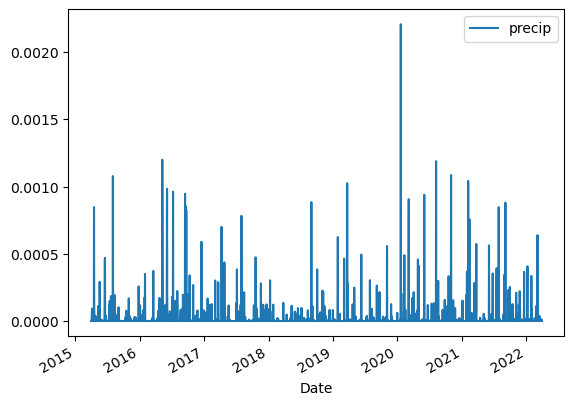

In [155]:
df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip.plot()
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync

## Get corresponding EASE grid to the sample request

In [156]:
distance = np.sqrt((target_lat-lat[0].values)**2+(target_lon-lon[0].values)**2)

minElement  = np.where(abs(distance) == np.nanmin(abs(distance)))
print(np.nanmin(distance))

if len(minElement[0])!=1:
    print('There are more than two closest cells')
    
lat_center = lat[0].values[minElement]
lon_center = lon[0].values[minElement]
ease_center_column = ease_column[0].values[minElement]
ease_center_row = ease_row[0].values[minElement]

print(f'The closest cell to the point ({target_lat}, {target_lon}) is\
      ({lat_center[0]}, {lon_center[0]}:\
      EASE GRID ({ease_center_row[0]}, {ease_center_column[0]})),\
      d={distance[minElement]} degrees')

bbox_lat_max = (lat[0].values[minElement]+lat[0].values[minElement[0][0]-1][minElement[1][0]])/2
bbox_lat_min = (lat[0].values[minElement]+lat[0].values[minElement[0][0]+1][minElement[1][0]])/2
bbox_lon_max = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]+1])/2
bbox_lon_min = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]-1])/2

bounding_box = f'{bbox_lon_min[0]},{bbox_lat_min[0]},{bbox_lon_max[0]},{bbox_lat_max[0]}'
print(bounding_box)


0.038834024
The closest cell to the point (-35.32395, 147.5348) is      (-35.29212188720703, 147.5570526123047:      EASE GRID (1281, 3508)),      d=[0.03883402] degrees
147.5103759765625,-35.335205078125,147.60372924804688,-35.24908447265625


## 3. Get MODIS data

### 3.1. Read catalog of MODIS data

In [162]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


def float_round(num, places = 0, direction = floor):
    return direction(num * (10**places)) / float(10**places)

buffer=0.2
bbox = [bbox_lon_min[0]-buffer, bbox_lat_min[0]-buffer, bbox_lon_max[0]+buffer, bbox_lat_max[0]+buffer]
bbox = [float_round(x, 10, round)for x in bbox] 
print(bbox)
year = "2019"
months = {
    "February": "2",
}

# Change this 
time_range = "2015-03-01/2022-03-30" # "2019-03-01/2019-04-30" # 

search = catalog.search(
    collections=["modis-15A3H-061"],
    bbox=bbox,
    datetime=time_range,
)
items = list(search.get_items())
print(f"Found: {len(items):d} datasets")

items_dict = dict()
for i, item in enumerate(items):
    items_dict[i] = item
print(items_dict.values())

[147.3103759766, -35.5352050781, 147.803729248, -35.0490844727]
Found: 32 datasets
dict_values([<Item id=MCD15A3H.A2019117.h30v12.061.2020293085830>, <Item id=MCD15A3H.A2019117.h29v12.061.2020293085159>, <Item id=MCD15A3H.A2019113.h30v12.061.2020292212653>, <Item id=MCD15A3H.A2019113.h29v12.061.2020292212214>, <Item id=MCD15A3H.A2019109.h30v12.061.2020292174905>, <Item id=MCD15A3H.A2019109.h29v12.061.2020292175331>, <Item id=MCD15A3H.A2019105.h30v12.061.2020292135644>, <Item id=MCD15A3H.A2019105.h29v12.061.2020292135214>, <Item id=MCD15A3H.A2019101.h30v12.061.2020292101226>, <Item id=MCD15A3H.A2019101.h29v12.061.2020292101223>, <Item id=MCD15A3H.A2019097.h30v12.061.2020292051705>, <Item id=MCD15A3H.A2019097.h29v12.061.2020292051710>, <Item id=MCD15A3H.A2019093.h30v12.061.2020291202312>, <Item id=MCD15A3H.A2019093.h29v12.061.2020291202303>, <Item id=MCD15A3H.A2019089.h30v12.061.2020291110525>, <Item id=MCD15A3H.A2019089.h29v12.061.2020291110529>, <Item id=MCD15A3H.A2019085.h30v12.061.20

### Get the MODIS composite for a day, and get the average over the EASE grid

In [163]:
# Get the unique dates from the list of items 
unique_dates = []
for i in range(len(items)):
    split_itemid = str(items[i]).split(".")
    unique_dates.append(split_itemid[1])
unique_dates = set(unique_dates)

# Iterate through the unique dates 
for i, unique_date in enumerate(unique_dates):
    item_for_the_unique_date = []
    print(f'processing{i}/{len(unique_dates)}')
    
    # Create a paired list of granules for the unique date
    for j, item in enumerate(items):
        if (unique_date in str(item)): 
            item_for_the_unique_date.append(item)
    
    # Iterate through the list of granules for the unique date 
    for k, item in enumerate(item_for_the_unique_date):
        
        # Read MODIS data from STAC server
        MODIS_data0 = stac_load(
            [item],
            crs="EPSG:4326",
            bands="Lai_500m",
            resolution=0.0045,
            bbox=bbox
        )
        
        # Scale the data 
        raster = item.assets["Lai_500m"].extra_fields["raster:bands"]
        MODIS_data = MODIS_data0["Lai_500m"] * raster[0]["scale"]
        MODIS_data.values[MODIS_data.values >=24.9] = np.nan

        # Merge the data 
        if k==0:
            MODIS_dataset = MODIS_data
        else:
            MODIS_dataset = MODIS_dataset.combine_first(MODIS_data)
        
        # Take an average over the grid
        if k==len(item_for_the_unique_date)-1:
            MODIS_dataset = MODIS_dataset.rename({'longitude': 'x', 'latitude': 'y'})
            MODIS_dataset_clipped = MODIS_dataset.rio.clip_box(minx=bbox_lon_min[0], miny=bbox_lat_min[0], maxx=bbox_lon_max[0], maxy=bbox_lat_max[0]).copy()
            # MODIS_dataset.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
            # MODIS_dataset_clipped.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
            meanLAI0 = MODIS_dataset.mean(dim=["x", "y"],skipna=True)
            meanLAI1 = pd.DataFrame([[meanLAI0.time.values[0], meanLAI0.values[0]]], columns=['Date', 'MODISmeanLAI_SMAPgrid'])
            meanLAI1['Date'] = pd.to_datetime(meanLAI1['Date'])
            meanLAI1.set_index('Date', inplace=True)
            if i==0:
                meanLAI_ts = meanLAI1
            else:
                meanLAI_ts = pd.concat([meanLAI_ts, meanLAI1])

processing0/16
processing1/16
processing2/16
processing3/16
processing4/16
processing5/16
processing6/16
processing7/16
processing8/16
processing9/16
processing10/16
processing11/16
processing12/16
processing13/16
processing14/16
processing15/16


### Get the timeseries of the sampled LAI

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip,MODISmeanLAI_SMAPgrid
Date,,,,,,
2019-02-26,NaN,NaN,NaN,0.000000e+00,True,0.456557
2019-02-27,NaN,0.060445,0.060445,0.000000e+00,True,0.471135
2019-02-28,0.108605,0.117227,0.112916,0.000000e+00,True,0.485714
2019-03-01,NaN,NaN,NaN,1.000000e-07,True,0.500293
2019-03-02,0.049050,0.068454,0.058752,0.000000e+00,True,0.514872


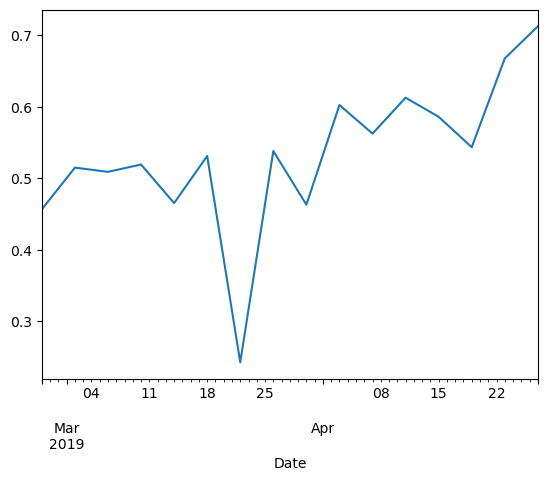

In [164]:
meanLAI_ts_daily = meanLAI_ts['MODISmeanLAI_SMAPgrid'].resample('D', axis=0).interpolate()
meanLAI_ts_daily.plot()
df_ts_sync = pd.merge(df_ts_sync, meanLAI_ts_daily, how='inner', left_index=True, right_index=True)
df_ts_sync.head()

## Get Ltheta with LAI 

### Get dS/dt


In [173]:
df_ts_sync['skippable'] = (df_ts_sync['soil_moisture_smapL3'].isnull()) & (df_ts_sync['noprecip']==True)
df_ts_sync.drop(df_ts_sync.index[df_ts_sync['skippable']==True], inplace=True)
df_ts_sync[['soil_moisture_smapL3','noprecip', 'MODISmeanLAI_SMAPgrid', 'skippable']].head(30)
# df_ts_sync.drop((df_ts_sync['soil_moisture_smapL3']))


,soil_moisture_smapL3,noprecip,MODISmeanLAI_SMAPgrid,skippable
Date,,,,
2019-02-27,0.060445,True,0.471135,False
2019-02-28,0.112916,True,0.485714,False
2019-03-02,0.058752,True,0.514872,False
2019-03-03,0.055123,True,0.513394,False
2019-03-05,0.172741,False,0.510438,False
2019-03-07,0.132565,True,0.511524,False
2019-03-08,0.097548,True,0.514089,False
2019-03-10,0.057017,True,0.519218,False
2019-03-11,0.057820,True,0.505726,False


In [175]:
df_ts_sync['dSdt'] = df_ts_sync['soil_moisture_smapL3'].diff()
df_ts_sync['dSdt'][df_ts_sync['dSdt']>0] = np.nan
df_ts_sync['dSdt(t+1)'] = df_ts_sync['dSdt'].shift(periods=-1).copy()
df_ts_sync[['soil_moisture_smapL3','dSdt(t+1)', 'noprecip', 'MODISmeanLAI_SMAPgrid']].head(30)

R:\Temp\ipykernel_9348\1509890939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_sync['dSdt'][df_ts_sync['dSdt']>0] = np.nan


,soil_moisture_smapL3,dSdt(t+1),noprecip,MODISmeanLAI_SMAPgrid
Date,,,,
2019-02-27,0.060445,NaN,True,0.471135
2019-02-28,0.112916,-0.054164,True,0.485714
2019-03-02,0.058752,-0.003629,True,0.514872
2019-03-03,0.055123,NaN,True,0.513394
2019-03-05,0.172741,-0.040176,False,0.510438
2019-03-07,0.132565,-0.035017,True,0.511524
2019-03-08,0.097548,-0.040531,True,0.514089
2019-03-10,0.057017,NaN,True,0.519218
2019-03-11,0.057820,-0.012795,True,0.505726


## Plot

In [176]:
# prep
lat = target_lat
lon = target_lon

smap_color = '#ff7f0e'
precip_color = '#779eb2'

title = f"{network_name}\n({lat:.2f}, {lon:.2f})"

save_title = f"{network_name}_{target_station}"

R:\Temp\ipykernel_9348\3388966319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_sync['values_while_drydown'][drydown_period==False] = np.nan
R:\Temp\ipykernel_9348\3388966319.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts_sync['values_while_drydown'][noprecip_with_buffer==False] = np.nan


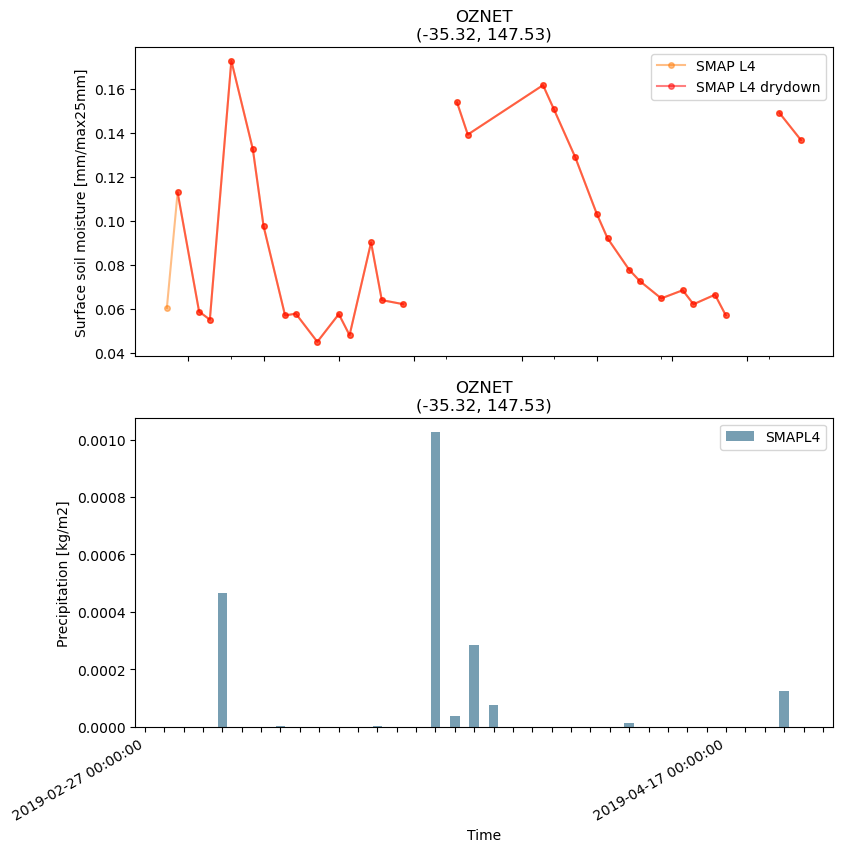

In [177]:
# Get drydown timeseries for plotting
df_ts_sync['values_while_drydown'] = df_ts_sync['soil_moisture_smapL3']
drydown_period = df_ts_sync['dSdt(t+1)'].notna()
drydown_period = drydown_period.shift(periods=+1) | drydown_period
df_ts_sync['values_while_drydown'][drydown_period==False] = np.nan
noprecip_with_buffer = (df_ts_sync['noprecip']==True) | (df_ts_sync['noprecip'].shift(periods=-1)==True)
df_ts_sync['values_while_drydown'][noprecip_with_buffer==False] = np.nan

# SMAP timeseries 
fig = plt.figure(figsize=(9, 10))
# fig.subplots(1, 2, sharey=True, sharex=True,  figsize=(10, 5))
ax1 = fig.add_subplot(2,1,1)
line1, = ax1.plot(df_ts_sync['soil_moisture_smapL3'], '-o', markersize=4, alpha=0.5, label='SMAP L4', color=smap_color)
line2, = ax1.plot(df_ts_sync['values_while_drydown'], '-o', markersize=4, alpha=0.5, label='SMAP L4 drydown', color='red')
xax = ax1.xaxis
ax1.set_title(title)
ax1.set_xlabel("Time")
# ax.set_ylabel("Volumetric soil water content [m^3/m^3]")
ax1.set_ylabel("Surface soil moisture [mm/max25mm]")
ax1.legend()

# Precipitation
ax2 =  fig.add_subplot(2,1,2)
df_ts_sync['precip'].plot.bar(y='first', ax=ax2, label='SMAPL4', color=precip_color, sharex=ax1)
ax2.set_title(title)
ax2.set_xlabel("Time")
ax2.set_ylabel("Precipitation [kg/m2]")
ax2.legend()
for ind, label in enumerate(ax2.get_xticklabels()):
    if ind % 30 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
fig.autofmt_xdate()
fig.savefig(f'../3_data_out/{save_title}_ts.png')






# Mask with precip



# 3D & 2D plot with LAI 



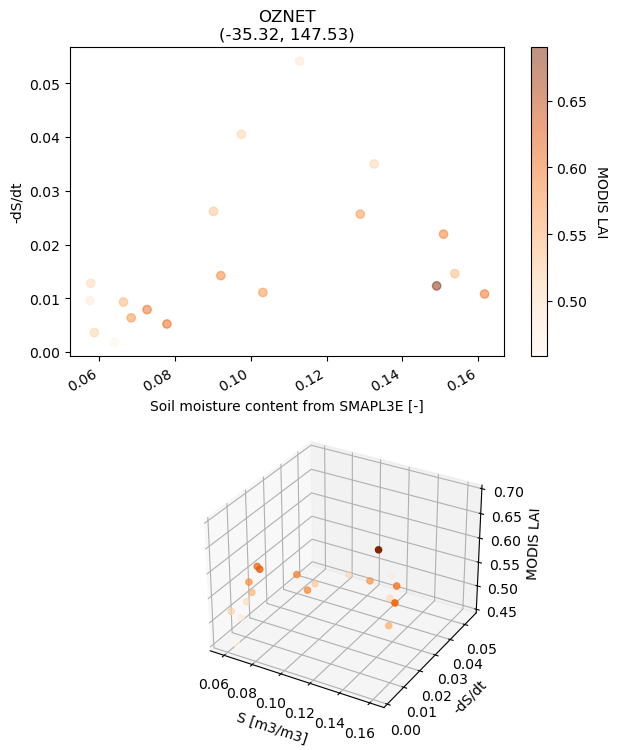

In [178]:
fig = plt.figure(figsize=(7, 10))
sm = df_ts_sync['soil_moisture_smapL3'][df_ts_sync['noprecip']].values
neg_dSdt = df_ts_sync['dSdt(t+1)'][df_ts_sync['noprecip']].values*-1
lai = df_ts_sync['MODISmeanLAI_SMAPgrid'][df_ts_sync['noprecip']].values

ax3 =  fig.add_subplot(2,1,1)
scatter = ax3.scatter(x=sm, y=neg_dSdt, c=lai, cmap= 'Oranges', marker='o', alpha=0.5, label='SMAP L4')
xax = ax3.xaxis
ax3.set_title(title)
ax3.set_xlabel("Soil moisture content from SMAPL3E [-]")
ax3.set_ylabel("-dS/dt")
cbar = plt.colorbar(scatter, ax=ax3)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('MODIS LAI', rotation=270)
fig.autofmt_xdate()

from mpl_toolkits import mplot3d

ax4 =  fig.add_subplot(2,1,2, projection='3d')

# Data for a three-dimensional line
ax4.scatter3D(sm, neg_dSdt, lai, c=lai, cmap='Oranges');
ax4.set_xlabel('S [m3/m3]')
ax4.set_ylabel('-dS/dt')
ax4.set_zlabel('MODIS LAI')

fig.savefig(f'../3_data_out/{save_title}_Ltheta.png')

